In [10]:
from mnist import load_mnist
import matplotlib.pyplot as plt
import numpy as np

train, validation, test = load_mnist()
X_train, y_train = train
X_validation, y_validation = validation
X_test, y_test = test



Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz


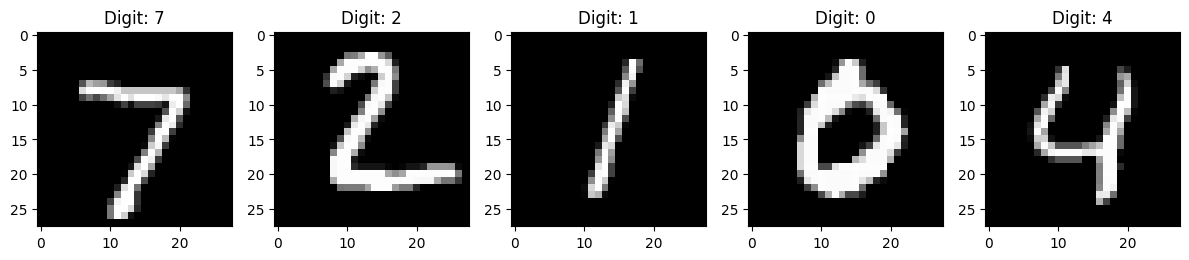

In [11]:
fig, axes = plt.subplots(1, 5, figsize=(12, 5)) 
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i].reshape(28, 28), cmap='gray')
    ax.set_title(f'Digit: {y_test[i]}')

plt.tight_layout()  
plt.show()

Алгоритм PCA

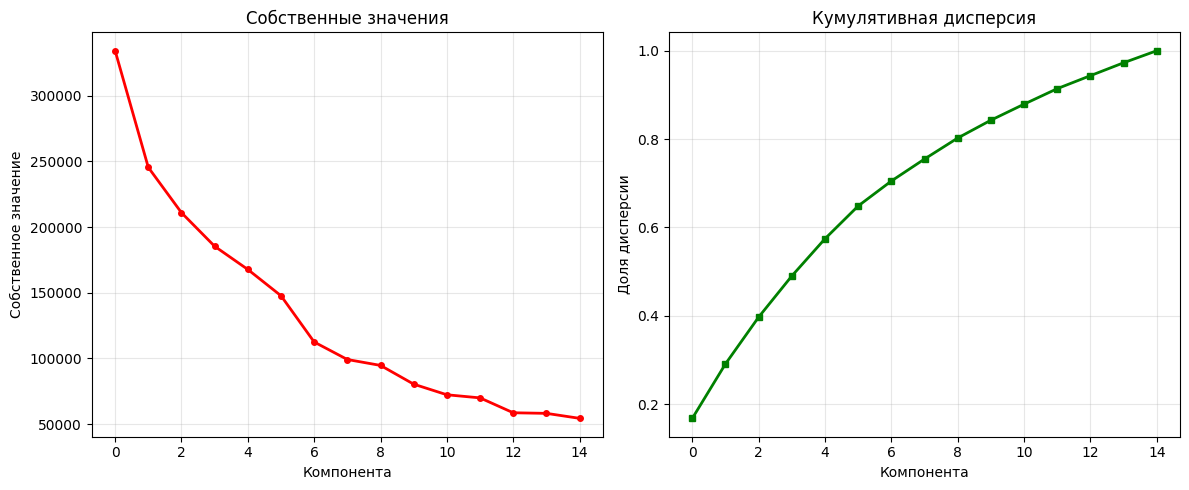

In [12]:
X = np.concatenate([train[0], validation[0], test[0]])
y = np.concatenate([train[1], validation[1], test[1]])

class my_PCA():
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.mean_ = None
        self.components_ = None
        self.explained_variance_ = None
        
    def fit(self, X):
        X_reshaped = X.reshape(-1, 784).astype(np.float32)
    
        self.mean_ = np.mean(X_reshaped, axis=0)
        X_centered = X_reshaped - self.mean_
        
        U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
        
        self.components_ = Vt.T
        self.explained_variance_ = (S ** 2) / (X_reshaped.shape[0] - 1)
        
        if self.n_components is not None:
            self.components_ = self.components_[:, :self.n_components]
            self.explained_variance_ = self.explained_variance_[:self.n_components]
        
        return self.components_, self.explained_variance_, X_centered.T @ X_centered, X_centered
        
    def transform(self, X):
        X_reshaped = X.reshape(-1, 784).astype(np.float32)
        X_centered = X_reshaped - self.mean_
        return X_centered @ self.components_
    
    def fit_transform(self, X):
        components, eigenvalues, cov_matrix, X_centered = self.fit(X)
        return X_centered @ components

pca = my_PCA(n_components=15)
components, eigenvalues, cov_matrix, X_centered = pca.fit(X)

plt.figure(figsize=(12, 5))
# Собственные значения
plt.subplot(1, 2, 1)
plt.plot(eigenvalues, 'r-o', linewidth=2, markersize=4)
plt.title('Собственные значения')
plt.xlabel('Компонента')
plt.ylabel('Собственное значение')
plt.grid(True, alpha=0.3)

# Кумулятивная дисперсия
plt.subplot(1, 2, 2)
cumulative_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)
plt.plot(cumulative_variance, 'g-s', linewidth=2, markersize=4)
plt.title('Кумулятивная дисперсия')
plt.xlabel('Компонента')
plt.ylabel('Доля дисперсии')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



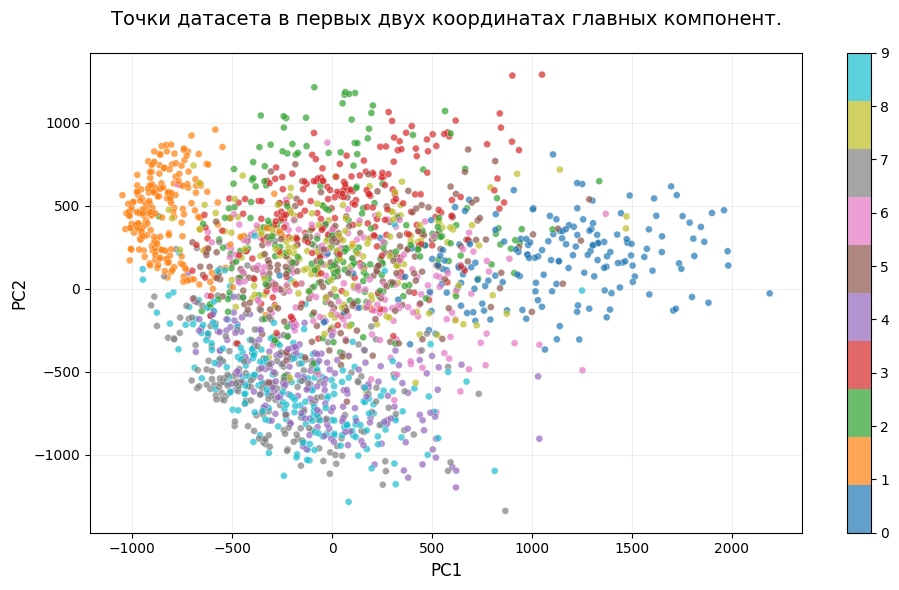

In [13]:
pca_2d = my_PCA(n_components=2)

X_train_flat = X_train.reshape(len(X_train), -1)
X_projected = pca_2d.fit_transform(X_train_flat)

plt.figure(figsize=(10, 6))

plot_indices = np.random.choice(len(X_projected), 2000, replace=False)
X_plot = X_projected[plot_indices]
y_plot = y_train[plot_indices]

scatter = plt.scatter(X_plot[:, 0], X_plot[:, 1], 
                     c=y_plot, cmap='tab10', s=25, alpha=0.7, 
                     edgecolors='w', linewidth=0.3)

plt.colorbar(scatter, ticks=range(10))
plt.title('Точки датасета в первых двух координатах главных компонент.', fontsize=14, pad=20)
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

Алгоритм KNN

In [33]:
class my_kNN():
    def __init__(self, n_neighbors=3):
        self.n_neighbors = n_neighbors
        
    def fit(self, X, y):
        self.X = (X.reshape(-1, 784).astype(np.float32) / 255.0)
        self.y = y
        
    def predict(self, X):
        X_flat = (X.reshape(-1, 784).astype(np.float32) / 255.0)
        res = np.zeros(len(X_flat), dtype=int)
        
        for i in range(len(X_flat)):
            distances = np.sqrt(np.sum((self.X - X_flat[i]) ** 2, axis=1))
            k_nearest = np.argpartition(distances, self.n_neighbors)[:self.n_neighbors]
            targets = self.y[k_nearest]
            res[i] = np.bincount(targets).argmax()
            
        return res

X_train = np.concatenate([train[0][:12000], validation[0][:3000]])
Y_train = np.concatenate([train[1][:12000], validation[1][:3000]])

kNN = my_kNN(10)
kNN.fit(X_train, Y_train)

y_pred = kNN.predict(test[0][:2000])
accuracy = np.mean(test[1][:2000] == y_pred)

print(f"Точность: {accuracy:.4f}") 

Точность: 0.9290
